# Alternative Classifiers and Experiments

In this Notebook the baseline will be re-established. But I will as well try to get insights of the models and steps used to create the baseline (CountVectorizer TfIdf).
I will as well try ngram size, optimization and other models like
- RandomForrest 
- KNeighborsClassifier
- DummyClassifier
- Naive Bayes

In [1]:
!pip uninstall -y fhnw-nlp-utils==0.1.3
!pip install git+https://github.com/TheoHelfenberger/fhnw-nlp-utils@fix_plot_feature_importance
!pip install pyarrow fastparquet

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe

import pandas as pd
import numpy as np

Found existing installation: fhnw-nlp-utils 0.2.13
Uninstalling fhnw-nlp-utils-0.2.13:
  Successfully uninstalled fhnw-nlp-utils-0.2.13
  Cloning https://github.com/TheoHelfenberger/fhnw-nlp-utils (to revision fix_plot_feature_importance) to /tmp/pip-req-build-1w1ky2fa
  Created wheel for fhnw-nlp-utils: filename=fhnw_nlp_utils-0.1.3-py3-none-any.whl size=17380 sha256=008d04d129f905221fb2b6fe374d8239800484e0118fdc47b15fa0271e1484a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-e0vumxi_/wheels/de/ab/03/ffa8cbb55e90d32c47d560a26718b8d65fe5305ed07c1f4917
Successfully built fhnw-nlp-utils
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# Create in Data cleaning
file = "data/german_news_articles_original_train_and_test_tokenized.parq"
data_all = load_dataframe(file)

In [3]:
data_all.sample(3)

,text_original,label,split,text_clean,token_clean,token_lemma,token_stem,token_clean_stopwords
1295,Dots-Chef Martin Ho möchte revitalisieren und ...,Kultur,train,Dots Chef Martin Ho möchte revitalisieren und ...,"[dots, chef, martin, ho, möchte, revitalisiere...","[dots, chef, martin, ho, mögen, revitalisieren...","[dot, chef, martin, ho, mocht, revitalisi, pre...","[dots, chef, martin, ho, möchte, revitalisiere..."
1355,Neue Welle von Gewalt in der Türkei: Angreifer...,International,train,Neue Welle von Gewalt in der Türkei Angreifer ...,"[neue, welle, gewalt, türkei, angreifer, nahme...","[neues, welle, gewalt, türkei, angreifer, nehm...","[neu, well, gewalt, turkei, angreif, nahm, pol...","[neue, welle, gewalt, türkei, angreifer, nahme..."
1619,"Auch den neuen ""Star Wars""-Film hat Lucas noch...",Web,train,Auch den neuen Star Wars Film hat Lucas noch n...,"[neuen, star, wars, film, lucas, gesehen, star...","[neu, star, wars, film, lucas, sehen, star, wa...","[neu, star, war, film, lucas, geseh, star, war...","[neuen, star, wars, film, lucas, gesehen, star..."


Once more have a look at the dataset. It is rather small with only 10K entries.
Also some categories are much more popular than other (web and panorama).

Total number of lines 10273
Percentage by label
Panorama         0.163341
Web              0.163243
International    0.147085
Wirtschaft       0.137350
Sport            0.116908
Inland           0.098803
Etat             0.065025
Wissenschaft     0.055777
Kultur           0.052468
Name: label, dtype: float64


<AxesSubplot:>

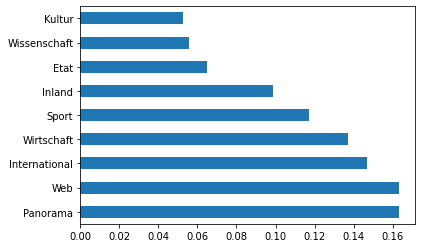

In [4]:
val_counts = data_all["label"].value_counts()

print(f'Total number of lines {len(data_all)}')
print('Percentage by label')
val_counts = val_counts / np.sum(val_counts)
print(val_counts)
val_counts.plot(kind='barh')

Implement the original split train/test again which was proposed by the authors of the dataset by using the column split.
Also split the train set further into train and validation.

In [57]:
from sklearn.model_selection import train_test_split

data_train_orig = data_all.loc[(data_all["split"] == "train")]
data_test_orig = data_all.loc[(data_all["split"] == "test")]

X_train, y_train = data_train_orig["token_lemma"], data_train_orig["label"]
X_test, y_test = data_test_orig["token_lemma"], data_test_orig["label"]

In [6]:
# Just for fun - what happends if we choose the label random?
# y_train = y_train.reindex(np.random.permutation(y_train.index))
# y_test = y_test.reindex(np.random.permutation(y_test.index))

In [126]:
%%time
# Basic Baseline model
# Noting to do in CountVectorizer as we already did tokenize and used stopwords -> use identity lambda
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

pipe = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])

CPU times: user 75 µs, sys: 115 µs, total: 190 µs
Wall time: 196 µs


In [127]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(preprocessor=<function <lambda> at 0x7f83b84ba1e0>,
                                 tokenizer=<function <lambda> at 0x7f83b84bad90>)),
                ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])

In [41]:
# Let's inspect CountVectorizer
import random

# Just to see which words are encoded by the CountVectorizer 
print('5 feature name of the CountVectorizer')
print(pipe['vec'].get_feature_names()[144164:144169])

print('\nVocubalary word mapping to position in ferature_names')
print(list(pipe['vec'].vocabulary_.items())[10:15])

print(f'\nVocubalary size {len(pipe["vec"].vocabulary_)}')

5 feature name of the CountVectorizer
['winter', 'winterabschiebestopp', 'winterausrüstung', 'winterausrüstungspflicht', 'winterbeginn']

Vocubalary word mapping to position in ferature_names
[('winter', 144164), ('ried', 105551), ('gekommen', 46138), ('jährig', 64051), ('erleiden', 34786)]

Vocubalary size 151217


Use a text headline from Tages Anzeiger to see what how the pipelines encodes it into tf-idf

In [49]:
# Use a text headline from Tages Anzeiger to see what how the pipelines encodes it into tf-idf
# This is the text
text = "Planlos Bundesrat schweigend Mehrheit egoistische Minderheit Die Schweiz steckt in der Pandemie Bewaltig in der Sackgasse und droht die Perspektive zu verlieren"
# Split into tokens
text_tokens = text.lower().split(" ")

feature_names = pipe['vec'].get_feature_names()
# Use only the 2 first steps of the pipelien (CountVectorizer and TfidfTransformer) and transform the given text 
# sparse matrix (vector) -> tfidf vector only 13 elements mapped (found)

transformted_text = pipe[:-1].transform([text_tokens]).toarray()[0]
#voc = pipe['vec'].vocabulary_
print("Position in feature name vector, tf-idf value, word")
[(p[0], p[1], feature_names[p[0]])  for p in enumerate(transformted_text) if p[1] > 0.0]

Position in feature name vector, tf-idf value, word


[(20556, 0.2566595587364793, 'bundesrat'),
 (28907, 0.3391536579801839, 'droht'),
 (30220, 0.3543767167485712, 'egoistische'),
 (81417, 0.15920079598072123, 'mehrheit'),
 (83293, 0.20675757153214225, 'minderheit'),
 (93279, 0.3543767167485712, 'pandemie'),
 (95229, 0.20461157702954938, 'perspektive'),
 (96452, 0.3283527258951063, 'planlos'),
 (107777, 0.27872782247643185, 'sackgasse'),
 (111854, 0.3283527258951063, 'schweigend'),
 (111893, 0.18128980837140823, 'schweiz'),
 (120384, 0.3391536579801839, 'steckt'),
 (135689, 0.12947604253664233, 'verlieren')]

In [128]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [50]:
from sklearn.metrics import classification_report
from fhnw.nlp.utils.ploting import plot_confusion_matrix
import pandas as pd

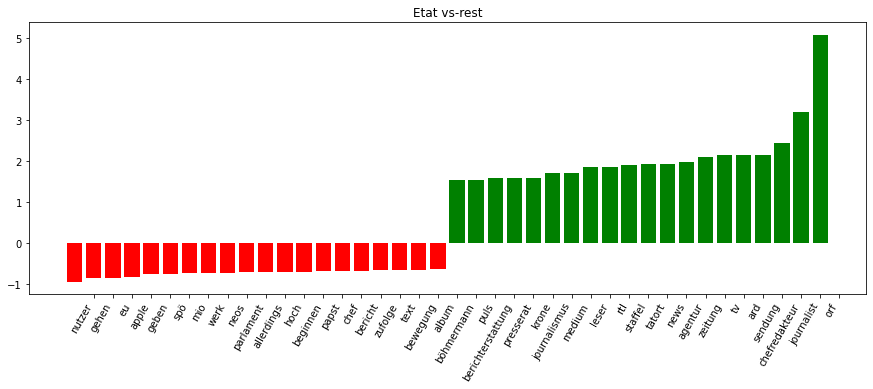

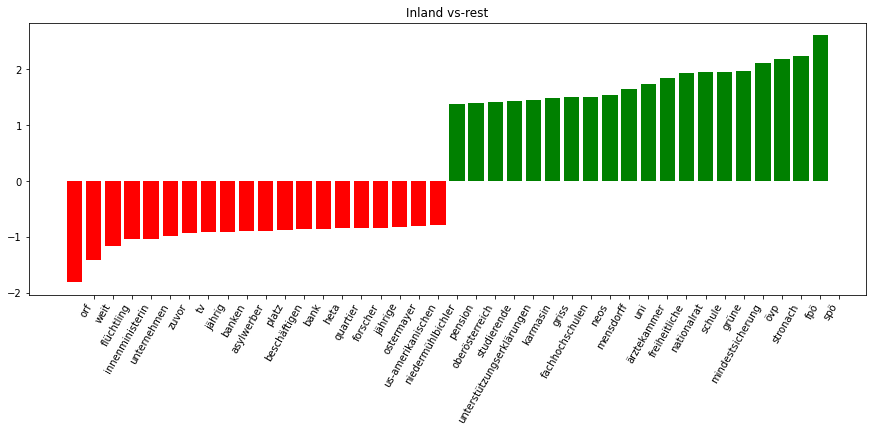

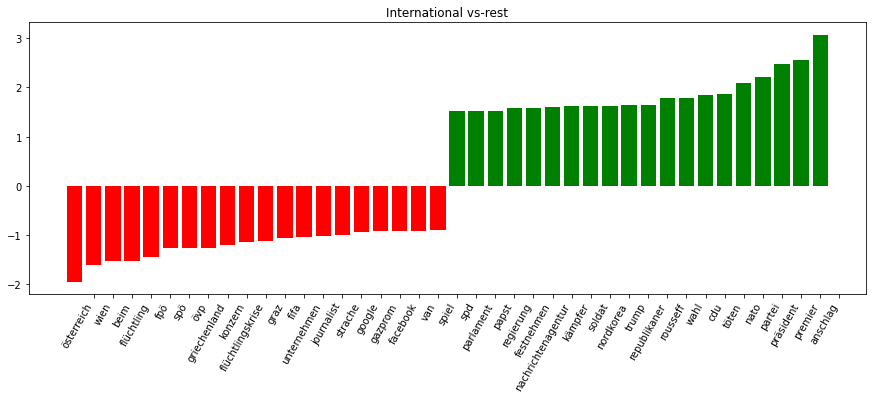

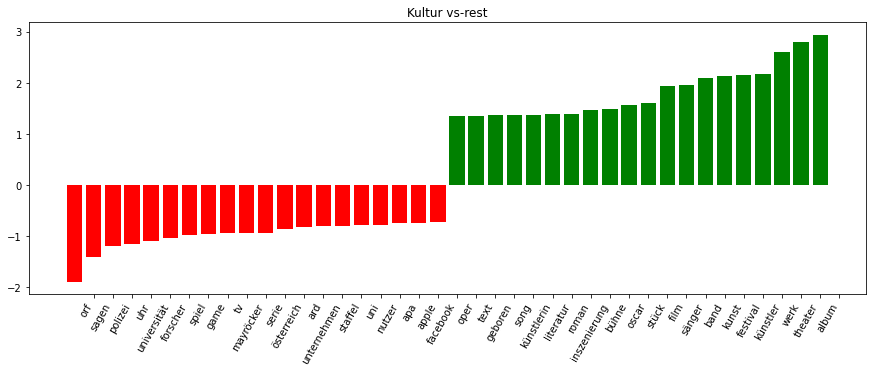

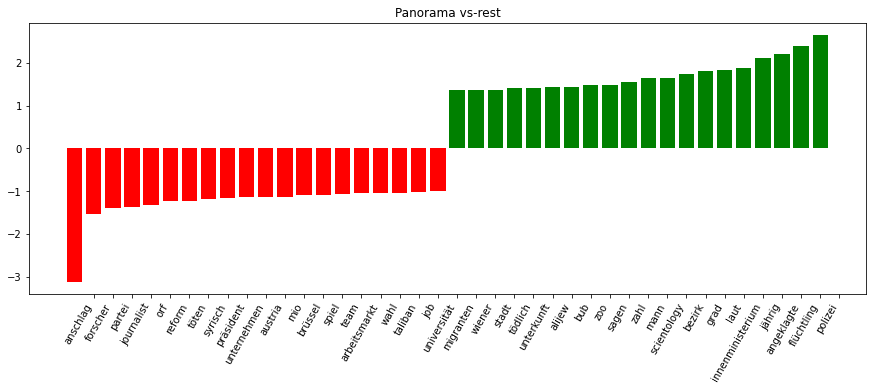

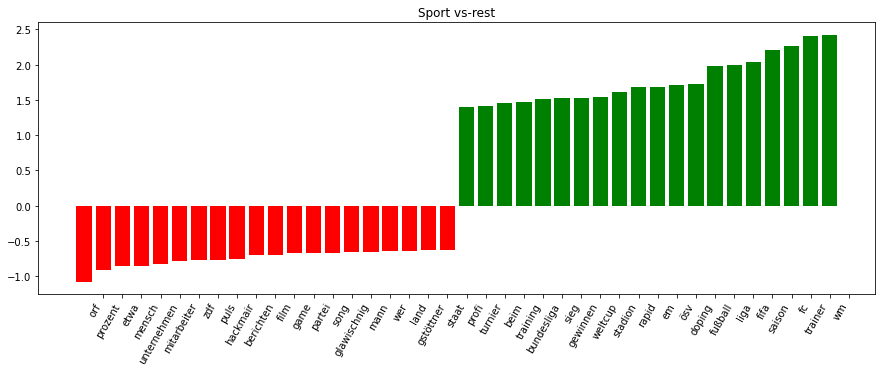

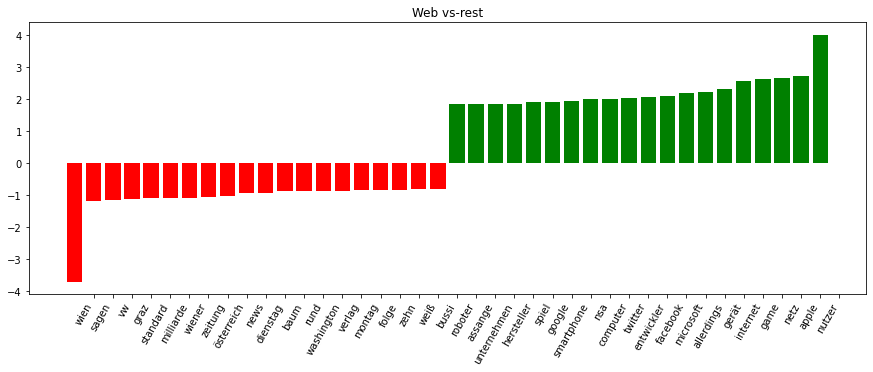

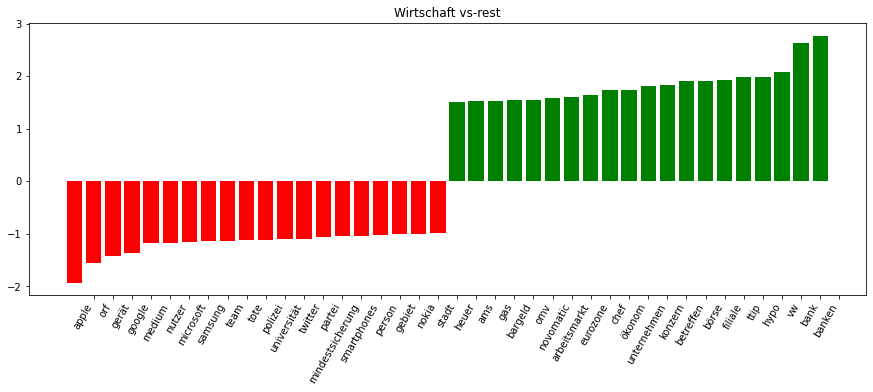

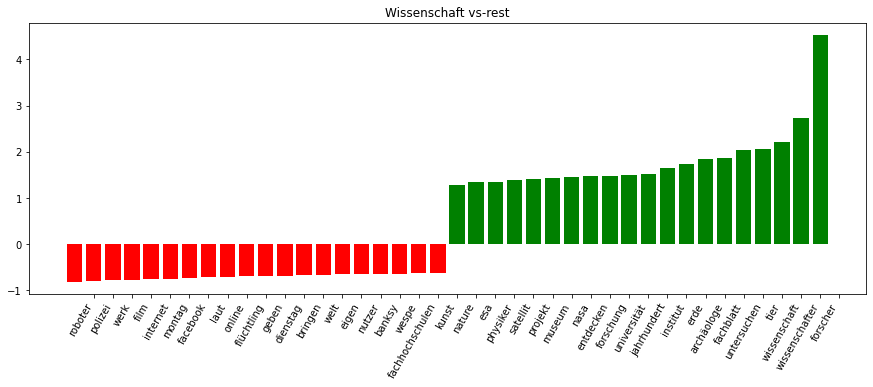

In [55]:
# Lets inspect the feature importance
# Each plot shows one class vs the rest (=all other classes)

from fhnw.nlp.utils.ploting import plot_feature_importance  
vectorizer = pipe.named_steps["vec"]
# only works since SGDClassifier uses LinearSVC by default
classifier = pipe.named_steps["clf"]

plot_feature_importance(classifier, vectorizer.get_feature_names())

In [59]:
# Let's predict from some text
row = 167
print(data_test_orig.iloc[row, 0], data_test_orig.iloc[row, 1])
pipe.predict(X_test.iloc[row].reshape(1,-1))

Großeinsatz von Armee und Polizei in südöstlicher Provinz Sirnak. Diyarbakir – Bei Einsätzen gegen die verbotene Arbeiterpartei Kurdistans (PKK) haben türkische Sicherheitskräfte im Südosten des Landes binnen zwei Tagen 23 mutmaßliche Rebellen getötet. Die Terroristen seien durch Soldaten und Polizisten in den Bezirken Cizre und Silopi in der Provinz Sirnak eliminiert worden, berichtete die regierungsnahe Nachrichtenagentur Anadolu am Donnerstag. Sondereinsatz In der Kurdenregion sind derzeit tausende Sicherheitskräfte im Sondereinsatz. Es gelten Ausgangssperren, in manchen Gegenden herrschen kriegsähnliche Zustände. Kurdische Aufständische hatten im Jahr 1984 im Südosten der Türkei einen Kampf um größere Autonomierechte begonnen. Der Konflikt der Regierung in Ankara mit der PKK eskalierte im Juni wieder, der vor drei Jahren eingeleitete Friedensprozess kam zum Erliegen. In dem Konflikt wurden in den vergangenen 30 Jahren etwa 45.000 Menschen getötet. International


array(['International'], dtype='<U13')

### OneVsOne Classification

In [64]:
%%time
# Let's try one vs one classification. Will need to compute 9 * 8 / 2 = 36 models
# Noting to do in CountVectorizer as we already did tokenize and used stopwords -> use identity lambda
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import Pipeline

pipeOneVsOne = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", OneVsOneClassifier(SGDClassifier()))
        ])
pipeOneVsOne.fit(X_train, y_train)
y_test_predOneVsOne = pipeOneVsOne.predict(X_test)

CPU times: user 3.1 s, sys: 6.64 s, total: 9.74 s
Wall time: 1.42 s


### Some other classifiers
DummyClassifier, KNeighborsClassifier and RandomForestClassifier


In [61]:
# Dummy Classifier
from sklearn.dummy import DummyClassifier
classifier = DummyClassifier(strategy='stratified')

pipeDummy = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", classifier)
        ])


pipeDummy.fit(X_train, y_train)
y_test_predDummy = pipeDummy.predict(X_test)

In [65]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()

pipeKNN = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", classifier)
        ])


pipeKNN.fit(X_train, y_train)
y_test_predKNN = pipeKNN.predict(X_test)

In [66]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()


pipeRF = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", classifier)
        ])


pipeRF.fit(X_train, y_train)
y_test_predRF = pipeRF.predict(X_test)

In [67]:
# Multinominal Naive Bayes
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()


pipeBayes = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", classifier)
        ])


pipeBayes.fit(X_train, y_train)
y_test_predBayes = pipeBayes.predict(X_test)

In [75]:
# Base classifiert 2 Grams
pipe2Gram = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])

pipe2Gram.fit(X_train, y_train)
y_test_2Gram = pipe2Gram.predict(X_test)

In [79]:
import os
import class_result

filename = 'data/overview_classification_results.csv'
if os.path.isfile(filename):
    os.remove('./data/pa_classification_report.csv')
    
class_result.append_to_classification_report('f1-baseline', y_test, y_test_pred)
class_result.append_to_classification_report('f1-one vs one', y_test, y_test_predOneVsOne)
class_result.append_to_classification_report('f1-baseline 2 Gram', y_test, y_test_2Gram)
class_result.append_to_classification_report('f1-kNN', y_test, y_test_predKNN)
class_result.append_to_classification_report('f1-Random Forest', y_test, y_test_predRF)
class_result.append_to_classification_report('f1-Naiv Bayes', y_test, y_test_predBayes)
df_classification_results = class_result.append_to_classification_report('f1-dummy clf', y_test, y_test_predDummy)

print("All F1 Score - Maximum highlighted")
df_classification_results.style.highlight_max(color = 'lightgreen', axis = 1)


All F1 Score - Maximum highlighted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,f1-baseline,f1-one vs one,f1-baseline 2 Gram,f1-kNN,f1-Random Forest,f1-Naiv Bayes,f1-dummy clf
Etat,0.857143,0.848000,0.806723,0.753846,0.568421,0.029412,0.031746
Inland,0.839024,0.827586,0.831683,0.770563,0.780488,0.717647,0.040201
International,0.848276,0.849123,0.823529,0.813115,0.788274,0.830450,0.190184
Kultur,0.854545,0.811321,0.890909,0.742268,0.804124,0.000000,0.055556
Panorama,0.822157,0.802228,0.804598,0.738028,0.717087,0.631791,0.197015
Sport,0.991667,0.978903,0.991667,0.962343,0.970464,0.948718,0.150794
Web,0.913433,0.900901,0.908012,0.835913,0.850000,0.756219,0.127796
Wirtschaft,0.851211,0.813559,0.823129,0.747253,0.719723,0.785965,0.141343
Wissenschaft,0.932203,0.902655,0.905983,0.796117,0.844037,0.000000,0.052632
accuracy,0.876459,0.857977,0.861868,0.799611,0.790856,0.694553,0.131323


### Is token-lemma the best choice

In [80]:
X_train_stem = data_train_orig["token_stem"]
X_test_stem = data_test_orig["token_stem"]

In [86]:
%%time
pipeStem = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1,1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])
pipeStem.fit(X_train_stem, y_train)
y_test_stem = pipeStem.predict(X_test_stem)


df_classification_results = class_result.append_to_classification_report('f1-baseline stemming', y_test, y_test_stem)

print("All F1 Score - Maximum highlighted")
df_classification_results.style.highlight_max(color = 'lightgreen', axis = 1)


All F1 Score - Maximum highlighted
CPU times: user 2.75 s, sys: 5.26 s, total: 8.01 s
Wall time: 1.33 s


,f1-baseline,f1-one vs one,f1-baseline 2 Gram,f1-kNN,f1-Random Forest,f1-Naiv Bayes,f1-dummy clf,f1-baseline stemming
Etat,0.857143,0.848000,0.806723,0.753846,0.568421,0.029412,0.031746,0.852713
Inland,0.839024,0.827586,0.831683,0.770563,0.780488,0.717647,0.040201,0.848485
International,0.848276,0.849123,0.823529,0.813115,0.788274,0.830450,0.190184,0.851351
Kultur,0.854545,0.811321,0.890909,0.742268,0.804124,0.000000,0.055556,0.859813
Panorama,0.822157,0.802228,0.804598,0.738028,0.717087,0.631791,0.197015,0.838150
Sport,0.991667,0.978903,0.991667,0.962343,0.970464,0.948718,0.150794,0.987448
Web,0.913433,0.900901,0.908012,0.835913,0.850000,0.756219,0.127796,0.925373
Wirtschaft,0.851211,0.813559,0.823129,0.747253,0.719723,0.785965,0.141343,0.851211
Wissenschaft,0.932203,0.902655,0.905983,0.796117,0.844037,0.000000,0.052632,0.905983
accuracy,0.876459,0.857977,0.861868,0.799611,0.790856,0.694553,0.131323,0.880350


In [ ]:
! pip install install git+https://github.com/scikit-optimize/scikit-optimize.git

In [88]:
from sklearn.metrics import f1_score, make_scorer

scoring_function = make_scorer(f1_score, average='weighted')

In [114]:
# https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html#sphx-glr-auto-examples-sklearn-gridsearchcv-replacement-py
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

pipeOpt = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1,1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])

params = {
    "vec__max_df": Real(0.5, 1.0), 
    "vec__min_df": Real(0.0001, 0.3, prior="log-uniform"), 
    #"vec__ngram_range": Categorical([(1, 1), (1, 2)]), 
    "tfidf__use_idf": Categorical([True, False]),
    "tfidf__norm": ["l1", "l2"],
    "tfidf__sublinear_tf": Categorical([True, False]),
    #"clf__class_weight": Categorical([None, "balanced"]),
    "clf__alpha": Real(0.0000001, 0.1, prior="log-uniform"),
}

opt = BayesSearchCV(
    pipeOpt,
    # (parameter space, # of evaluations)
    [(params, 30)],
    scoring=scoring_function,
    n_jobs=-1, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=2
) 

In [115]:
%%time
_ = opt.fit(X_train_stem, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [116]:
print(opt.best_score_)
print(opt.best_params_)

0.8597760074936686
OrderedDict([('clf__alpha', 3.217634382422315e-05), ('tfidf__norm', 'l2'), ('tfidf__sublinear_tf', True), ('tfidf__use_idf', True), ('vec__max_df', 1.0), ('vec__min_df', 0.0001)])


In [120]:
# best_params_ = eval("[('clf__alpha', 6.232887524573945e-05), ('tfidf__norm', 'l2'), ('tfidf__sublinear_tf', False), ('tfidf__use_idf', True), ('vec__max_df', 1.0), ('vec__min_df', 0.00032291887960613543)]")
best_params_ = dict(eval("[('clf__alpha', 4.055784991805354e-05), ('tfidf__norm', 'l2'), ('tfidf__sublinear_tf', False), ('tfidf__use_idf', True), ('vec__max_df', 0.5), ('vec__min_df', 0.0001)]"))
best_params_stem_ = dict(eval("[('clf__alpha', 3.217634382422315e-05), ('tfidf__norm', 'l2'), ('tfidf__sublinear_tf', True), ('tfidf__use_idf', True), ('vec__max_df', 1.0), ('vec__min_df', 0.0001)]"))

best_params_, best_params_stem_

({'clf__alpha': 4.055784991805354e-05,
  'tfidf__norm': 'l2',
  'tfidf__sublinear_tf': False,
  'tfidf__use_idf': True,
  'vec__max_df': 0.5,
  'vec__min_df': 0.0001},
 {'clf__alpha': 3.217634382422315e-05,
  'tfidf__norm': 'l2',
  'tfidf__sublinear_tf': True,
  'tfidf__use_idf': True,
  'vec__max_df': 1.0,
  'vec__min_df': 0.0001})

In [121]:
#print(opt.best_score_)
#print(opt.best_params_)

pipeOpt = Pipeline([
         ("vec", CountVectorizer(ngram_range=(1,1), tokenizer=lambda x: x,preprocessor=lambda x: x, stop_words=None)),
         ('tfidf', TfidfTransformer()),
         ("clf", SGDClassifier())
        ])

pipeOpt.set_params(**best_params_stem_)
pipeOpt.fit(X_train_stem, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(min_df=0.0001,
                                 preprocessor=<function <lambda> at 0x7f83b327e7b8>,
                                 tokenizer=<function <lambda> at 0x7f83b327e488>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf', SGDClassifier(alpha=3.217634382422315e-05))])

In [122]:
y_test_pred_opti = pipeOpt.predict(X_test_stem)

df_classification_results = class_result.append_to_classification_report('f1-baseline optimized', y_test, y_test_pred_opti)

print("All F1 Score - Maximum highlighted")
df_classification_results.style.highlight_max(color = 'lightgreen', axis = 1)

All F1 Score - Maximum highlighted


,f1-baseline,f1-one vs one,f1-baseline 2 Gram,f1-kNN,f1-Random Forest,f1-Naiv Bayes,f1-dummy clf,f1-baseline stemming,f1-baseline optimized
Etat,0.857143,0.848000,0.806723,0.753846,0.568421,0.029412,0.031746,0.852713,0.859375
Inland,0.839024,0.827586,0.831683,0.770563,0.780488,0.717647,0.040201,0.848485,0.869565
International,0.848276,0.849123,0.823529,0.813115,0.788274,0.830450,0.190184,0.851351,0.851351
Kultur,0.854545,0.811321,0.890909,0.742268,0.804124,0.000000,0.055556,0.859813,0.878505
Panorama,0.822157,0.802228,0.804598,0.738028,0.717087,0.631791,0.197015,0.838150,0.826347
Sport,0.991667,0.978903,0.991667,0.962343,0.970464,0.948718,0.150794,0.987448,0.991667
Web,0.913433,0.900901,0.908012,0.835913,0.850000,0.756219,0.127796,0.925373,0.923077
Wirtschaft,0.851211,0.813559,0.823129,0.747253,0.719723,0.785965,0.141343,0.851211,0.844291
Wissenschaft,0.932203,0.902655,0.905983,0.796117,0.844037,0.000000,0.052632,0.905983,0.905983
accuracy,0.876459,0.857977,0.861868,0.799611,0.790856,0.694553,0.131323,0.880350,0.881323


In [102]:
y_test_pred_opti = pipeOpt.predict(X_test)

report = classification_report(y_test, y_test_pred)
print("Test SGDClassifier on token_lemma:")
print(report)
report = classification_report(y_test, y_test_pred_opti)
print("Test SGDClassifier optimized")
print(report)

Test SGDClassifier on token_lemma:
               precision    recall  f1-score   support

         Etat       0.92      0.81      0.86        67
       Inland       0.83      0.84      0.84       102
International       0.88      0.81      0.85       151
       Kultur       0.84      0.87      0.85        54
     Panorama       0.81      0.84      0.82       168
        Sport       0.99      0.99      0.99       120
          Web       0.92      0.91      0.91       168
   Wirtschaft       0.83      0.87      0.85       141
 Wissenschaft       0.90      0.96      0.93        57

     accuracy                           0.88      1028
    macro avg       0.88      0.88      0.88      1028
 weighted avg       0.88      0.88      0.88      1028

Test SGDClassifier optimized
               precision    recall  f1-score   support

         Etat       0.93      0.81      0.86        67
       Inland       0.80      0.83      0.82       102
International       0.89      0.83      0.86       1

In [131]:
import os
import class_result

filename = 'data/overview_classification_results.csv'
if os.path.isfile(filename):
    os.remove(filename)
    
class_result.append_to_classification_report('f1-baseline', y_test, y_test_pred, filename=filename)
class_result.append_to_classification_report('f1-one vs one', y_test, y_test_predOneVsOne, filename=filename)
class_result.append_to_classification_report('f1-baseline 2 Gram', y_test, y_test_2Gram, filename=filename)
class_result.append_to_classification_report('f1-kNN', y_test, y_test_predKNN, filename=filename)
class_result.append_to_classification_report('f1-Random Forest', y_test, y_test_predRF, filename=filename)
class_result.append_to_classification_report('f1-Naiv Bayes', y_test, y_test_predBayes, filename=filename)
class_result.append_to_classification_report('f1-baseline stemming', y_test, y_test_stem, filename=filename)
class_result.append_to_classification_report('f1-baseline stemming optimized', y_test, y_test_pred_opti, filename=filename)
df_classification_results = class_result.append_to_classification_report('f1-dummy clf', y_test, y_test_predDummy, filename=filename)

print("All F1 Score - Maximum highlighted")
df_classification_results.style.highlight_max(color = 'lightblue', axis = 1)


All F1 Score - Maximum highlighted


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,f1-baseline,f1-one vs one,f1-baseline 2 Gram,f1-kNN,f1-Random Forest,f1-Naiv Bayes,f1-baseline stemming,f1-baseline stemming optimized,f1-dummy clf
Etat,0.850394,0.848000,0.806723,0.753846,0.568421,0.029412,0.852713,0.859375,0.031746
Inland,0.835821,0.827586,0.831683,0.770563,0.780488,0.717647,0.848485,0.869565,0.040201
International,0.855172,0.849123,0.823529,0.813115,0.788274,0.830450,0.851351,0.851351,0.190184
Kultur,0.854545,0.811321,0.890909,0.742268,0.804124,0.000000,0.859813,0.878505,0.055556
Panorama,0.829412,0.802228,0.804598,0.738028,0.717087,0.631791,0.838150,0.826347,0.197015
Sport,0.991667,0.978903,0.991667,0.962343,0.970464,0.948718,0.987448,0.991667,0.150794
Web,0.908012,0.900901,0.908012,0.835913,0.850000,0.756219,0.925373,0.923077,0.127796
Wirtschaft,0.849315,0.813559,0.823129,0.747253,0.719723,0.785965,0.851211,0.844291,0.141343
Wissenschaft,0.924370,0.902655,0.905983,0.796117,0.844037,0.000000,0.905983,0.905983,0.052632
accuracy,0.876459,0.857977,0.861868,0.799611,0.790856,0.694553,0.880350,0.881323,0.131323
